In [1]:
import pandas as pd
from smartbeta.smartfactor import SmartFactor
from smartbeta.ai_factor import AiFactor
from data_provider.nestlib.market_info import Frequency
from tqdm import tqdm
import pdb
from backtest_batch_service_bartest import backtest_batch_service

In [2]:
class FilterFactor(AiFactor):
    '''
    该类负责将一个因子对另一个因子进行Union操作并留下共有部分的因子
    请使用工具函数generate_filter_factor
    '''

    def _x_rules(self):
        """
        在该方法中指定因子预处理方式
        
        更多方法，参见因子合成文档中的因子标准化方法
        """
        return []

    def _build_ai_model(self, dateTime, training_set):
        """
        按指定frequency，滚动生成复合因子数据
        
        Parameters
        -----------
        dateTime: datetime类型
            当前时间
        trainint_set: pd.DataFrame
            训练集
        Return
        -------
        pd.Series类型，key为securityId, 值为factor value
        """

        ret = self.ff._get_training_XY(dateTime, training_set)
        df_factor=ret[2]

        
        column_name=df_factor.columns
        source_factor_name = self._factor_param['source_factor_name']
        col_name_list = list(column_name)
        col_name_list.remove(source_factor_name)
        filter_factor_name = col_name_list
        
        source_se = df_factor.loc[:,source_factor_name]
        filter_df = df_factor.loc[:,filter_factor_name]
        
        source_se = source_se.reset_index().set_index('security_code')[source_factor_name]
        
        source_factor_cut_part = self._factor_param['cut_part']
        if 'filter_source_percentile' in self._factor_param:
            if self._factor_param['filter_source_percentile'] != None:
                
                filter_percentile=self._factor_param['filter_source_percentile']

                filter_df = filter_df.rank(pct=True, axis=0)
                filter_df = filter_df.reset_index().set_index('security_code')
                
                tickers_to_drop = []
                for filter_name in tqdm(filter_factor_name):
                    try:
                        if source_factor_cut_part[filter_name] == 'high':
                            drop_li = filter_df[filter_df[filter_name]>=(filter_percentile)].index.tolist()
                            tickers_to_drop.extend(drop_li)
                        elif source_factor_cut_part[filter_name] == 'low':
                            drop_li = filter_df[filter_df[filter_name]<=(1-filter_percentile)].index.tolist()
                            tickers_to_drop.extend(drop_li)                            
                        else:
                            drop_li_1 = filter_df[filter_df[filter_name]<=(1-filter_percentile)].index.tolist()
                            tickers_to_drop.extend(drop_li_1)
                            drop_li_2 = filter_df[filter_df[filter_name]>=(filter_percentile)].index.tolist()
                            tickers_to_drop.extend(drop_li_2)                            
                    except Exception as e:
                        print(str(e))
                        print(filter_name)
                tickers_to_drop = list(set(tickers_to_drop))
                source_se = source_se.drop(labels=tickers_to_drop)

        
        result = source_se
        return result

In [3]:
def generate_filter_factor(filter_factor_list, source_factor_name, 
                            new_factor_name, from_dt, to_dt, filter_percentile=None, filter_ascending=False, echo=False, is_external=False):
    '''
    This function would generate a new factor which is the source_factor but filtered by another.
    @param filter_factor_name: the factor name to filter the source
    @param source_factor_name: the source factor name whose factor value would be reserved.
    @param new_factor_name: the generated new factor name.
    @param filter_percentile: a value between 0~1, the percentile to filter the filter factor. 
                              It allows to reserve only top factors of filter_factor.
                              Set this value to None if no percentile filter needed       
                                     
    @param filter_ascending: True to reserve only head factor values of on filter percentile,
                             False to reserve only tail factor values of filter percentile

    @param is_external: set to True if it is an industry factor or index factor
                             
    @return: No return value. Check private factor list for the generated factor.
    '''

    dic = {}
    for any_dic in filter_factor_list:
            if any_dic['factor_name'] in dic.keys():
                dic.update({any_dic['factor_name']:'high and low'})
            else:
                dic.update({any_dic['factor_name']:any_dic['cut_part']})
    
    factor_name_li = list(dic.keys())
    
    subFactors = [{'factor_name':factor_name_li[n],'factor_direction':1} for n in range(len(factor_name_li))]
    subFactors.append({'factor_name':source_factor_name, 'factor_direction':1})
    

    
    # 指定复合因子参数
    factor_parameters={"subFactors": subFactors,
                       "source_factor_name":source_factor_name,
                       "frequency": 'daily',
                       "lagCycleNumber": 0,
                       "use_ranks_as_x": False,
                       "use_ranks_as_y": False,
                       "class_percentile": False,
                       "class_remove_neural": False,
                       "treat_na": 'drop', 
                       "include_latest": False,
                       "filter_source_percentile": filter_percentile,
                       "filter_source_ascending": filter_ascending,
                       'dailyreturn_factor_name':'dailyreturn',
                       'cut_part':dic}

    ab = FilterFactor(
        factor_name=new_factor_name, # 复合因子的名称
        tickers='A', # 复合因子对应的股票池
        factor_parameters=factor_parameters,
    )

    # 是否使用cache
    ab.set_use_factor_cache(False)
    if is_external is True:
        ab.set_factor_external(True)
    #从数据库清空因子，以便重新录入
    ab.generate_factor_and_store(from_dt, to_dt, echo=echo)
    print('因子合成完毕，已成功入库!')

读取风险过滤后有效的公共因子

In [4]:
df = pd.read_csv('filter_factor_result_df/new_benchmark_60stocks_backtest_public_factor_filter_0.98.csv')
sharpe_ratio_benchmark = df.loc[df[df['factor_name']=='new_filted_prd_factor_benchmark'].index[0],'sharpe_ratio']
effective_factor_df = df.loc[:df[df['factor_name']=='new_filted_prd_factor_benchmark'].index[0]-1,:]
effective_factor_df = effective_factor_df.drop(effective_factor_df[effective_factor_df['sharpe_ratio']<sharpe_ratio_benchmark].index)
effective_factor_li = effective_factor_df.factor_name.tolist()

ori_effective_factor_li = []
for x in effective_factor_li:
    spt = x.split('_')
    ori_factor = '_'.join(spt[9:-1])
    
    cut_part = spt[-1]

    ori_factor_dic = {'factor_name':ori_factor,'cut_part':cut_part}
    ori_effective_factor_li.append(ori_factor_dic)

读取风险过滤后有效的alpha91因子

In [6]:
df = pd.read_csv('filter_factor_result_df/new_benchmark_100stocks_backtest_neutralized_alpha191_factor_filter_0.98.csv')
sharpe_ratio_benchmark = df.loc[df[df['factor_name']=='new_filted_prd_factor_benchmark'].index[0],'sharpe_ratio']
effective_factor_df = df.loc[:df[df['factor_name']=='new_filted_prd_factor_benchmark'].index[0]-1,:]
effective_factor_df = effective_factor_df.drop(effective_factor_df[effective_factor_df['sharpe_ratio']<sharpe_ratio_benchmark].index)
effective_factor_li = effective_factor_df.factor_name.tolist()

ori_effective_factor_li = []
for factor in effective_factor_li:
    splt = factor.split('_')
    ori_factor = 'neutralized_shared_alpha191_risk_'+splt[-2]
    
    cut_part = splt[-1]
    ori_factor_dic = {'factor_name':ori_factor,'cut_part':cut_part}    
    ori_effective_factor_li.append(ori_factor_dic)

In [8]:
target_li = [
# {'factor_name': 'shared_alpha191_risk_087', 'cut_part': 'high'},
#  {'factor_name': 'shared_alpha191_risk_006', 'cut_part': 'high'},
#  {'factor_name': 'shared_alpha191_risk_063', 'cut_part': 'low'},
#  {'factor_name': 'shared_alpha191_risk_014', 'cut_part': 'high'},
#  {'factor_name': 'shared_alpha191_risk_107', 'cut_part': 'low'},
#  {'factor_name': 'shared_alpha191_risk_022', 'cut_part': 'high'},
#  {'factor_name': 'shared_alpha191_risk_043', 'cut_part': 'high'},
#  {'factor_name': 'shared_alpha191_risk_048', 'cut_part': 'low'},
# {'factor_name': 'currentratio', 'cut_part': 'low'},
#  {'factor_name': 'ltd2equity_lr', 'cut_part': 'high'},
#  {'factor_name': 'operatingprofitmargin', 'cut_part': 'high'},
#  {'factor_name': 'ebit2ev', 'cut_part': 'high'},
#  {'factor_name': 'turnoverrate', 'cut_part': 'low'},
#  {'factor_name': 'roic_ttm', 'cut_part': 'high'},
#  {'factor_name': 'ta2equity', 'cut_part': 'high'},
#  {'factor_name': 'roa_ttm', 'cut_part': 'high'},
#  {'factor_name': 'ep_ttm', 'cut_part': 'high'},
#  {'factor_name': 'netprofitmargin', 'cut_part': 'high'},
#  {'factor_name': 'equity2totaldebt', 'cut_part': 'low'},
#  {'factor_name': 'ta2debt', 'cut_part': 'low'},
#  {'factor_name': 'weeklyturnoveravg', 'cut_part': 'low'},
#  {'factor_name': 'ep_lyr', 'cut_part': 'high'},
#  {'factor_name': 'volatility', 'cut_part': 'low'},
#  {'factor_name': 'berryratio', 'cut_part': 'high'},
#  {'factor_name': 'beta_60d', 'cut_part': 'high'},
#  {'factor_name': 'volatility', 'cut_part': 'high'},
#  {'factor_name': 'cashflowyield_lyr', 'cut_part': 'high'},
#  {'factor_name': 'normalizedabormalvolume', 'cut_part': 'low'},
#  {'factor_name': 'sales2ev', 'cut_part': 'high'},
#  {'factor_name': 'cashflowcover', 'cut_part': 'high'},
#  {'factor_name': 'totaldebt2equity', 'cut_part': 'high'},
#  {'factor_name': 'caturnover', 'cut_part': 'low'},
#  {'factor_name': 'caturnover', 'cut_part': 'high'},
#  {'factor_name': 'cashflowyield_ttm', 'cut_part': 'high'},
#  {'factor_name': 'tskew', 'cut_part': 'high'},
#  {'factor_name': 'earnings_sq_yoy', 'cut_part': 'high'},
#  {'factor_name': 'macrossover', 'cut_part': 'high'},
#  {'factor_name': 'salesgrowth', 'cut_part': 'high'},
#  {'factor_name': 'ldebt2ta', 'cut_part': 'high'},
#  {'factor_name': 'ebit2ev', 'cut_part': 'low'},
#  {'factor_name': 'stdturnoverrate', 'cut_part': 'low'},
#  {'factor_name': 'unleverbeta_120d', 'cut_part': 'high'},
#  {'factor_name': 'sp_ttm', 'cut_part': 'high'},
#  {'factor_name': 'monthlyvolumevolatility', 'cut_part': 'high'},
#  {'factor_name': 'earnings_ltg', 'cut_part': 'low'},
#  {'factor_name': 'highrstd', 'cut_part': 'low'},
#  {'factor_name': 'assetgrowth', 'cut_part': 'low'},
#  {'factor_name': 'earnings_stg', 'cut_part': 'high'},
#  {'factor_name': 'tata', 'cut_part': 'low'},
#  {'factor_name': 'earnings_sq_yoy', 'cut_part': 'low'},
#  {'factor_name': 'beta_120d', 'cut_part': 'high'},
#  {'factor_name': 'ep_ttm', 'cut_part': 'low'},
#  {'factor_name': 'ev2ebitda', 'cut_part': 'high'},
#  {'factor_name': 'realizedvolatility', 'cut_part': 'low'},
#  {'factor_name': 'saleearnings_sq_yoy', 'cut_part': 'low'},
#  {'factor_name': 'dailyreturn', 'cut_part': 'high'},
#  {'factor_name': 'naturnover', 'cut_part': 'high'},
#  {'factor_name': 'berryratio', 'cut_part': 'low'},
#  {'factor_name': 'momentum_3m', 'cut_part': 'low'},
#  {'factor_name': 'salesgrowth', 'cut_part': 'low'},
#  {'factor_name': 'volatilityreg', 'cut_part': 'high'}
# {'factor_name': 'earnings_sq_yoy', 'cut_part': 'low'},
# {'factor_name': 'roa_ttm', 'cut_part': 'low'},
# {'factor_name': 'roegrowth2', 'cut_part': 'low'},
# {'factor_name': 'ebit2ev', 'cut_part': 'low'},
# {'factor_name': 'saleearnings_sq_yoy', 'cut_part': 'low'},
# {'factor_name': 'operatingprofitmargin', 'cut_part': 'low'},
# {'factor_name': 'roegrowth1', 'cut_part': 'low'},
# {'factor_name': 'momentum_12m_1m', 'cut_part': 'low'},
# {'factor_name': 'expwgtmomentum', 'cut_part': 'low'},
# {'factor_name': 'roic_ttm', 'cut_part': 'low'},
# {'factor_name': 'roe_ttm', 'cut_part': 'low'},
# {'factor_name': 'gpoagrowth', 'cut_part': 'low'},
# {'factor_name': 'ldebt2ta', 'cut_part': 'high'},
# {'factor_name': 'normalizedabormalvolume', 'cut_part': 'low'},
# {'factor_name': 'salesgrowth', 'cut_part': 'low'}
{'factor_name': 'assetturnover', 'cut_part': 'low'},
{'factor_name': 'caturnover', 'cut_part': 'low'},
# {'factor_name': 'lowrstd', 'cut_part': 'low'},
# {'factor_name': 'salesgrowth', 'cut_part': 'low'},
# {'factor_name': 'ldebt2ta', 'cut_part': 'high'},
# {'factor_name': 'realizedvolatility', 'cut_part': 'low'},
# {'factor_name': 'operatingprofitmargin', 'cut_part': 'high'},
# {'factor_name': 'earnings_sq_yoy', 'cut_part': 'high'},
# {'factor_name': 'freecashflowyield_ttm', 'cut_part': 'high'},
# {'factor_name': 'netprofitmargin', 'cut_part': 'high'},
# {'factor_name': 'monthlyvolumevolatility', 'cut_part': 'high'},
# {'factor_name': 'unleverbeta_20d', 'cut_part': 'high'},
# {'factor_name': 'sales2ev', 'cut_part': 'high'},
# {'factor_name': 'roegrowth2', 'cut_part': 'low'},
# {'factor_name': 'weightmomentum', 'cut_part': 'low'},
# {'factor_name': 'sales2ev', 'cut_part': 'low'},
# {'factor_name': 'cashflowcover', 'cut_part': 'high'},
# {'factor_name': 'ta2debt', 'cut_part': 'low'},
# {'factor_name': 'operatingprofitmargin', 'cut_part': 'low'},
# {'factor_name': 'unleverbeta_120d', 'cut_part': 'high'},
# {'factor_name': 'roe_ttm', 'cut_part': 'low'},
# {'factor_name': 'saleearnings_sq_yoy', 'cut_part': 'high'},
# {'factor_name': 'expwgtmomentum', 'cut_part': 'low'},
# {'factor_name': 'ta2equity', 'cut_part': 'high'},
# {'factor_name': 'ltd2equity_lr', 'cut_part': 'high'},
# {'factor_name': 'salesgrowth', 'cut_part': 'high'},
# {'factor_name': 'monthlyvolumevolatility', 'cut_part': 'low'},
# {'factor_name': 'totaldebt2equity', 'cut_part': 'high'},
# {'factor_name': 'equity2totaldebt', 'cut_part': 'low'},
# {'factor_name': 'naturnover', 'cut_part': 'low'}
# {'factor_name': 'shared_alpha191_risk_111', 'cut_part': 'low'},
# {'factor_name': 'shared_alpha191_risk_108', 'cut_part': 'low'},
# {'factor_name': 'shared_alpha191_risk_179', 'cut_part': 'low'},
# {'factor_name': 'shared_alpha191_risk_001', 'cut_part': 'low'},
# {'factor_name': 'shared_alpha191_risk_082', 'cut_part': 'low'},
# {'factor_name': 'shared_alpha191_risk_067', 'cut_part': 'low'},
# {'factor_name': 'shared_alpha191_risk_063', 'cut_part': 'low'},
# {'factor_name': 'shared_alpha191_risk_162', 'cut_part': 'low'},
{'factor_name': 'neutralized_shared_alpha191_risk_164', 'cut_part': 'high'},
# {'factor_name': 'neutralized_shared_alpha191_risk_188', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_113', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_056', 'cut_part': 'high'},
# {'factor_name': 'neutralized_shared_alpha191_risk_111', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_047', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_120', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_176', 'cut_part': 'high'},
# {'factor_name': 'neutralized_shared_alpha191_risk_082', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_129', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_130', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_075', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_108', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_182', 'cut_part': 'high'},
# {'factor_name': 'neutralized_shared_alpha191_risk_184', 'cut_part': 'high'}
]

In [4]:
# # backtest 60 stocks
# target_li = [
# # {'factor_name': 'shared_alpha191_risk_105', 'cut_part': 'high'},
# # {'factor_name': 'shared_alpha191_risk_108', 'cut_part': 'low'},
# # {'factor_name': 'earnings_sq_yoy', 'cut_part': 'low'},
# # {'factor_name': 'roa_ttm', 'cut_part': 'low'},
# # {'factor_name': 'roegrowth2', 'cut_part': 'low'},
# # {'factor_name': 'ebit2ev', 'cut_part': 'low'},
# # {'factor_name': 'saleearnings_sq_yoy', 'cut_part': 'low'},
# # {'factor_name': 'operatingprofitmargin', 'cut_part': 'low'},
# # {'factor_name': 'roegrowth1', 'cut_part': 'low'},
# # {'factor_name': 'momentum_12m_1m', 'cut_part': 'low'},
# # {'factor_name': 'expwgtmomentum', 'cut_part': 'low'},
# # {'factor_name': 'roic_ttm', 'cut_part': 'low'},
# # {'factor_name': 'roe_ttm', 'cut_part': 'low'},
# # {'factor_name': 'gpoagrowth', 'cut_part': 'low'},
# # {'factor_name': 'ldebt2ta', 'cut_part': 'high'},
# # {'factor_name': 'normalizedabormalvolume', 'cut_part': 'low'},
# # {'factor_name': 'salesgrowth', 'cut_part': 'low'}
# ]

In [8]:
target_li = [
{'factor_name': 'assetturnover', 'cut_part': 'low'},
{'factor_name': 'caturnover', 'cut_part': 'low'},
{'factor_name': 'shared_alpha191_risk_111', 'cut_part': 'low'},
{'factor_name': 'shared_alpha191_risk_108', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_164', 'cut_part': 'high'},
# {'factor_name': 'neutralized_shared_alpha191_risk_188', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_113', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_056', 'cut_part': 'high'},
# {'factor_name': 'neutralized_shared_alpha191_risk_111', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_047', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_120', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_176', 'cut_part': 'high'},
# {'factor_name': 'neutralized_shared_alpha191_risk_082', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_129', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_130', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_075', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_108', 'cut_part': 'low'},
# {'factor_name': 'neutralized_shared_alpha191_risk_182', 'cut_part': 'high'},
# {'factor_name': 'neutralized_shared_alpha191_risk_184', 'cut_part': 'high'}
]

In [ ]:
# new_name = 'select_top_2public_2unneu_1neu_aplha191_everyday_100_new_benchmark_public_filter_factor'
new_name = 'test!!'
generate_filter_factor(target_li, 'new_filted_prd_factor_benchmark', 
                            new_name, 20200518, 20210204, filter_percentile=0.98, filter_ascending=False, echo=False, is_external=False)

对新生成的风险过滤后因子效果进行回测验证

In [10]:
def backtest_factors(factor):
    backtest_batch_service.run_backtest_batch(backtest_name,factor,start_date,end_date)
    shared_list.append(backtest_batch_service.result_analysis(backtest_name,factor))

The sharp_ratio of test!!= 0.3419869746488324
The sharp_ratio of new_filted_prd_factor_benchmark= 0.31351673148736525


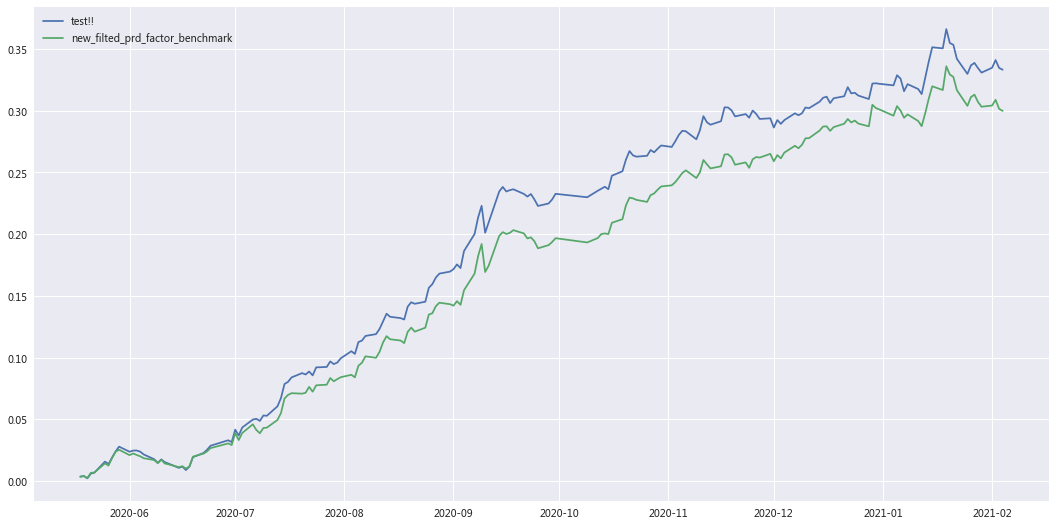

In [11]:
factor_li = [new_name,'new_filted_prd_factor_benchmark']
start_date = '20200518'
end_date = '20210204'
backtest_name = 'backtest_new_benchmark_public_factor_filter_0.98'

shared_list = []
for fct in factor_li:
    backtest_factors(fct)

li = []
for ele in shared_list:
    li.append(ele)
unsorted_df = pd.DataFrame(li,columns=['factor_name','sharpe_ratio','cum_ret'])
sorted_by='cum_ret'
sorted_df = unsorted_df.sort_values(by=sorted_by,ascending=False)
# sorted_df.to_csv('filter_factor_result_df/'+backtest_name+'.csv')

sorted_factor_li = sorted_df.factor_name

# plot_one = True:将所有alpha曲线画在同一个图中
# sorted_by = 'sharpe_ratio' or 'cum_ret'
backtest_batch_service.batch_analysis(backtest_name,sorted_factor_li,plot_one=True)


In [12]:
new_name = 'select_top_2public_1_neu_aplha191_everyday_100_new_benchmark_public_filter_factor'

The sharp_ratio of select_top_2public_1_neu_aplha191_everyday_100_new_benchmark_public_filter_factor= 0.33059240502601933
The sharp_ratio of new_filted_prd_factor_benchmark= 0.31351673148736486


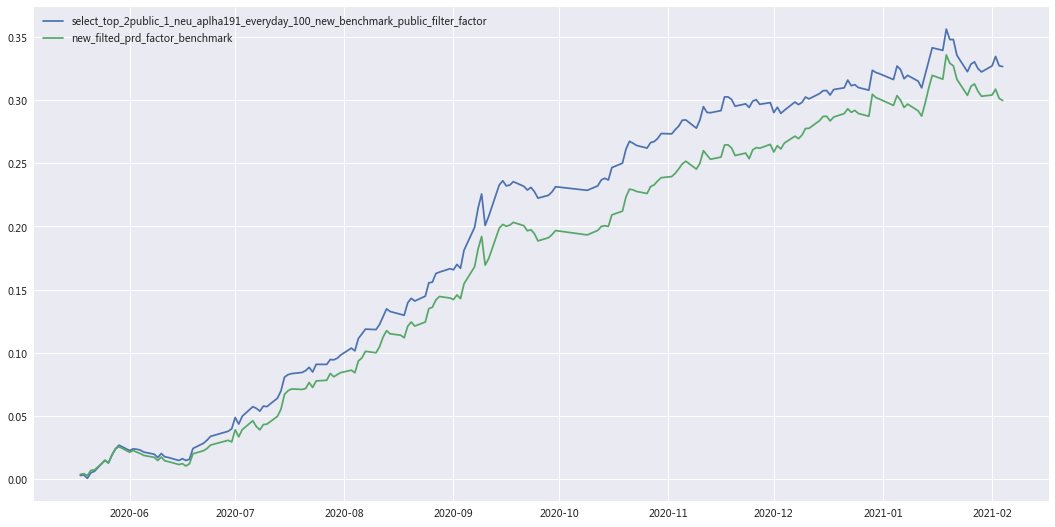

In [13]:
factor_li = [new_name,'new_filted_prd_factor_benchmark']
start_date = '20200518'
end_date = '20210204'
backtest_name = 'backtest_new_benchmark_public_factor_filter_0.98'

shared_list = []
for fct in factor_li:
    backtest_factors(fct)

li = []
for ele in shared_list:
    li.append(ele)
unsorted_df = pd.DataFrame(li,columns=['factor_name','sharpe_ratio','cum_ret'])
sorted_by='cum_ret'
sorted_df = unsorted_df.sort_values(by=sorted_by,ascending=False)
# sorted_df.to_csv('filter_factor_result_df/'+backtest_name+'.csv')

sorted_factor_li = sorted_df.factor_name

# plot_one = True:将所有alpha曲线画在同一个图中
# sorted_by = 'sharpe_ratio' or 'cum_ret'
backtest_batch_service.batch_analysis(backtest_name,sorted_factor_li,plot_one=True)